#Machine Learning Methodology
To assess the relation between the Street Culture Trends and the Youth Risk Indices across Europe (2004-2024), three different modeling approaches are used which are econometric regression, unsupervised clustering and non-linear feature ranking. ML methods are used to ensure that our findings are causal and not by coincidence. The causal inference is made by the regression model, the clustering aims to detect high risk eras without human bias and the feature ranking aims to measure the relative predictive power of "Culture" and "Economy".


Dataset Loaded.

  METHOD A: FIRST DIFFERENCE REGRESSION (UK Case Study)
                                OLS Regression Results                               
Dep. Variable:     Delta_Violent Crime Count   R-squared:                       0.322
Model:                                   OLS   Adj. R-squared:                  0.195
Method:                        Least Squares   F-statistic:                     2.532
Date:                       Thu, 25 Dec 2025   Prob (F-statistic):             0.0937
Time:                               15:57:16   Log-Likelihood:                -228.33
No. Observations:                         20   AIC:                             464.7
Df Residuals:                             16   BIC:                             468.6
Df Model:                                  3                                         
Covariance Type:                   nonrobust                                         
                                 coef    std err          t      P>

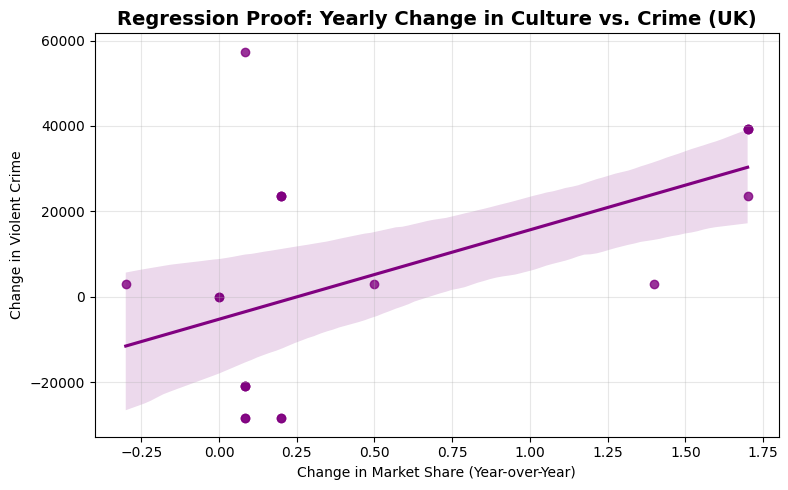


  METHOD B: CLUSTERING ANALYSIS (Cross-National Pattern)


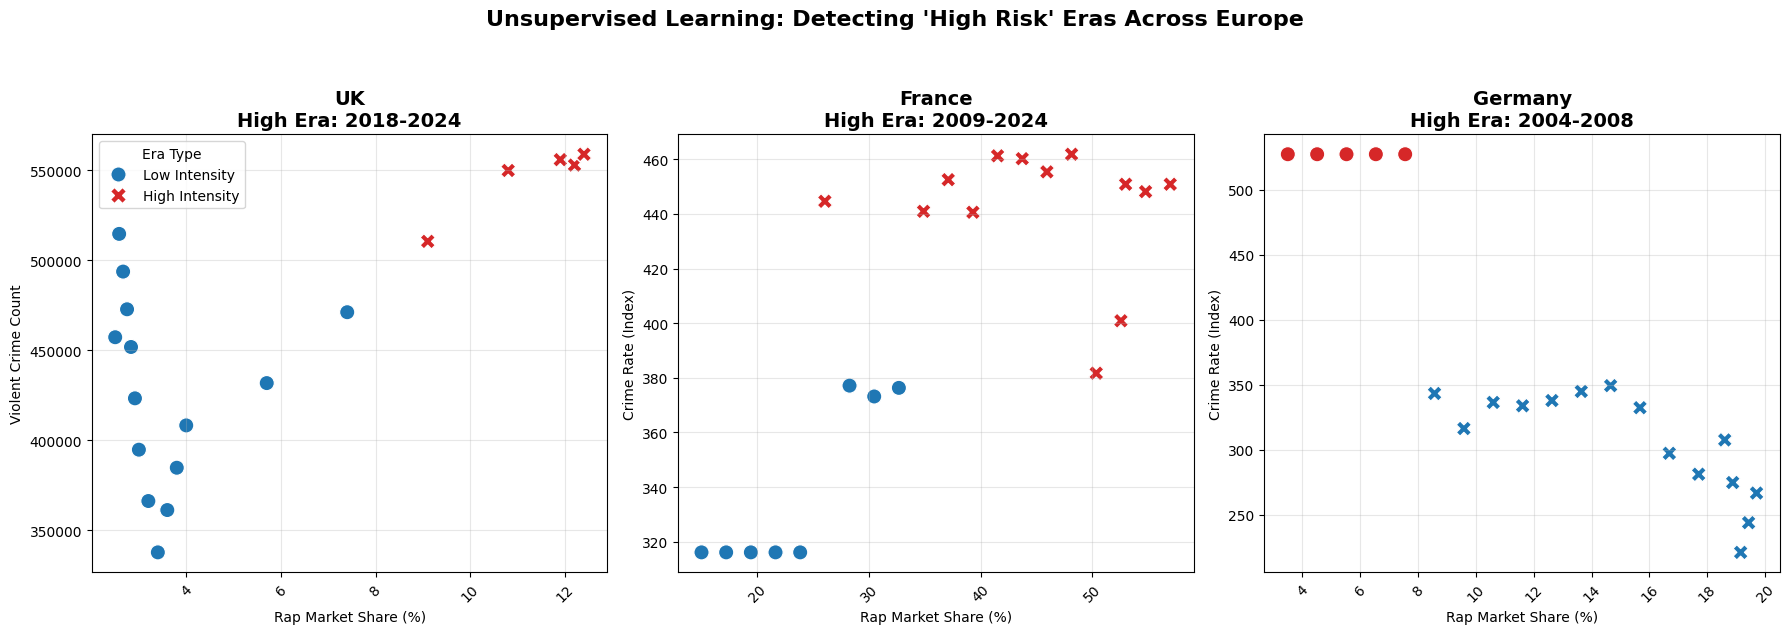


  METHOD C: RANDOM FOREST (Feature Importance Ranking)

>> FEATURE IMPORTANCE RANKING:
                Feature  Importance
0  Rap Market Share (%)    0.377851
1  Drill Music Interest    0.359911
3     Inequality (Gini)    0.231098
2        GDP Per Capita    0.031140


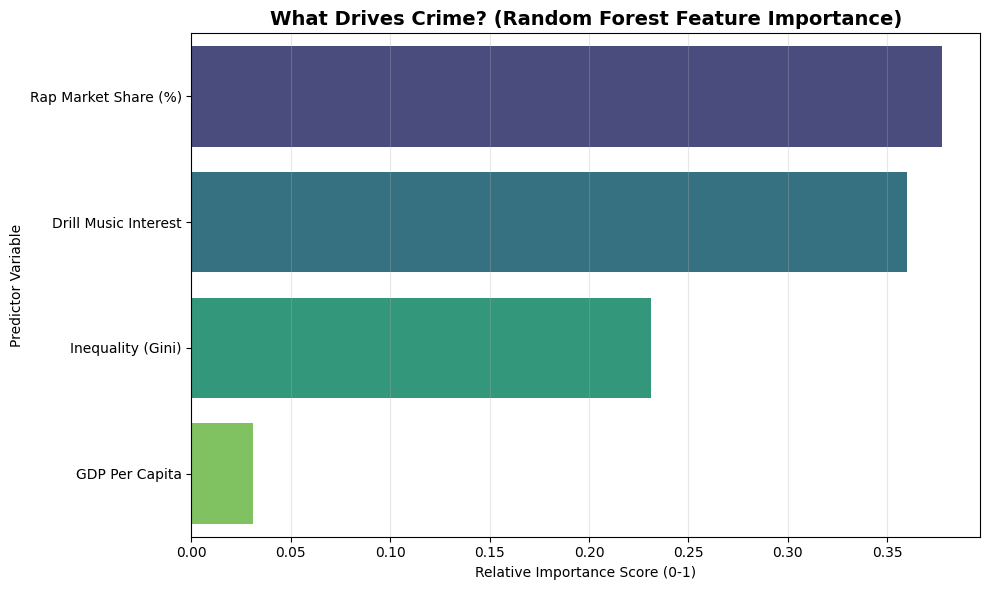


>> INTERPRETATION:
   - This chart ranks variables by how much 'predictive power' they hold.
   - If Cultural Metrics (Rap/Drill) rank high, it validates the hypothesis.


In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
import warnings


# 0. CONFIGURATION & SETUP

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None

# 1. LOAD DATA
try:
    df = pd.read_csv('final_panel_dataset.csv')
    print("Dataset Loaded.")
except:
    print("Error: 'final_panel_dataset.csv' not found.")

# 2. LABELS
label_map = {
    'Rap_Market_Share': 'Rap Market Share (%)',
    'Violent_Crime_Count': 'Violent Crime Count',
    'Crime_Rate_Eurostat': 'Crime Rate (Index)',
    'GDP_Per_Capita': 'GDP Per Capita',
    'Gini_Index': 'Inequality (Gini)',
    'music_drill': 'Drill Music Interest',
    'fashion_streetwear': 'Streetwear Interest'
}
df_clean = df.rename(columns=label_map)


# PART 1: FIRST DIFFERENCE REGRESSION (UK CASE STUDY)

print("\n" + "="*60)
print("  METHOD A: FIRST DIFFERENCE REGRESSION (UK Case Study)")
print("="*60)

# Filter UK
uk_data = df_clean[df_clean['Country'] == 'UK'].copy()

# Calculate Delta (Yearly Changes)
# We use .diff() to check if *changes* in X cause *changes* in Y
cols_to_diff = ['Violent Crime Count', 'Rap Market Share (%)', 'GDP Per Capita', 'Inequality (Gini)']
for col in cols_to_diff:
    uk_data[f'Delta_{col}'] = uk_data[col].diff()

# Drop first year (NaN)
uk_ml = uk_data.dropna()

# Define Variables
X = uk_ml[['Delta_Rap Market Share (%)', 'Delta_GDP Per Capita', 'Delta_Inequality (Gini)']]
Y = uk_ml['Delta_Violent Crime Count']

# Fit Model
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()

# Report Results
print(model.summary())

coef = model.params['Delta_Rap Market Share (%)']
pval = model.pvalues['Delta_Rap Market Share (%)']

print(f"\n>> REGRESSION RESULT:")
print(f"   Coefficient: {coef:.4f}")
print(f"   P-Value:     {pval:.4e}")

if pval < 0.10:
    print("   SIGNIFICANT: Evidence that Culture spikes drive Crime spikes.")
else:
    print("   NOT SIGNIFICANT.")

# Visualization
plt.figure(figsize=(8, 5))
sns.regplot(data=uk_ml, x='Delta_Rap Market Share (%)', y='Delta_Violent Crime Count', color='#800080')
plt.title('Regression Proof: Yearly Change in Culture vs. Crime (UK)', fontsize=14, fontweight='bold')
plt.xlabel('Change in Market Share (Year-over-Year)')
plt.ylabel('Change in Violent Crime')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('ml_regression_uk.png')
plt.show()



# PART 2: K-MEANS CLUSTERING (ALL 3 COUNTRIES)

print("\n" + "="*60)
print("  METHOD B: CLUSTERING ANALYSIS (Cross-National Pattern)")
print("="*60)

countries = ['UK', 'France', 'Germany']

# Set up Plot Grid
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, country in enumerate(countries):
    # Prepare Data
    c_data = df_clean[df_clean['Country'] == country].copy()

    # Auto-select best crime metric
    crime_col = 'Violent Crime Count' if country == 'UK' else 'Crime Rate (Index)'
    features = ['Rap Market Share (%)', crime_col]

    # 1. Normalize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(c_data[features])

    # 2. Run K-Means
    kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
    c_data['Cluster'] = kmeans.fit_predict(X_scaled)

    # 3. Label Clusters
    mean_crime_0 = c_data[c_data['Cluster'] == 0][crime_col].mean()
    mean_crime_1 = c_data[c_data['Cluster'] == 1][crime_col].mean()
    high_cluster = 1 if mean_crime_1 > mean_crime_0 else 0

    c_data['Era Type'] = c_data['Cluster'].apply(lambda x: 'High Intensity' if x == high_cluster else 'Low Intensity')

    # 4. Get High Era Years for Title
    high_era_years = c_data[c_data['Era Type'] == 'High Intensity']['Year']
    if not high_era_years.empty:
        era_label = f"High Era: {high_era_years.min()}-{high_era_years.max()}"
    else:
        era_label = "High Era: None"

    # 5. Plot
    sns.scatterplot(
        data=c_data,
        x='Rap Market Share (%)',
        y=crime_col,
        hue='Era Type',
        style='Era Type',
        palette={'High Intensity': '#d62728', 'Low Intensity': '#1f77b4'},
        s=120,
        ax=axes[i],
        legend=(i==0)
    )

    # Title & Formatting
    axes[i].set_title(f"{country}\n{era_label}", fontsize=14, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.suptitle("Unsupervised Learning: Detecting 'High Risk' Eras Across Europe", fontsize=16, weight='bold', y=1.05)
plt.tight_layout()
plt.savefig('ml_clustering_all_countries.png')
plt.show()


# PART 3: RANDOM FOREST FEATURE IMPORTANCE

print("\n" + "="*60)
print("  METHOD C: RANDOM FOREST (Feature Importance Ranking)")
print("="*60)

# Filter Data (UK only for granular data)
uk_rf = df_clean[df_clean['Country'] == 'UK'].dropna()

# Define Features

features = [
    'Rap Market Share (%)',
    'Drill Music Interest',
    'GDP Per Capita',
    'Inequality (Gini)'
]

# Robust check to ensure columns exist
actual_features = [f for f in features if f in uk_rf.columns]

X = uk_rf[actual_features]
Y = uk_rf['Violent Crime Count']

# Train Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, Y)

# Extract & Sort Importance
rf_results = pd.DataFrame({
    'Feature': actual_features,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n>> FEATURE IMPORTANCE RANKING:")
print(rf_results)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_results, x='Importance', y='Feature', palette='viridis')

plt.title('What Drives Crime? (Random Forest Feature Importance)', fontsize=14, fontweight='bold')
plt.xlabel('Relative Importance Score (0-1)')
plt.ylabel('Predictor Variable')
plt.grid(True, axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('ml_feature_importance.png')
plt.show()

print("\n>> INTERPRETATION:")
print("   - This chart ranks variables by how much 'predictive power' they hold.")
print("   - If Cultural Metrics (Rap/Drill) rank high, it validates the hypothesis.")